In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import cloveFunctions as clv

## compute true negatives (expression of gene_x given copy number gene_x)

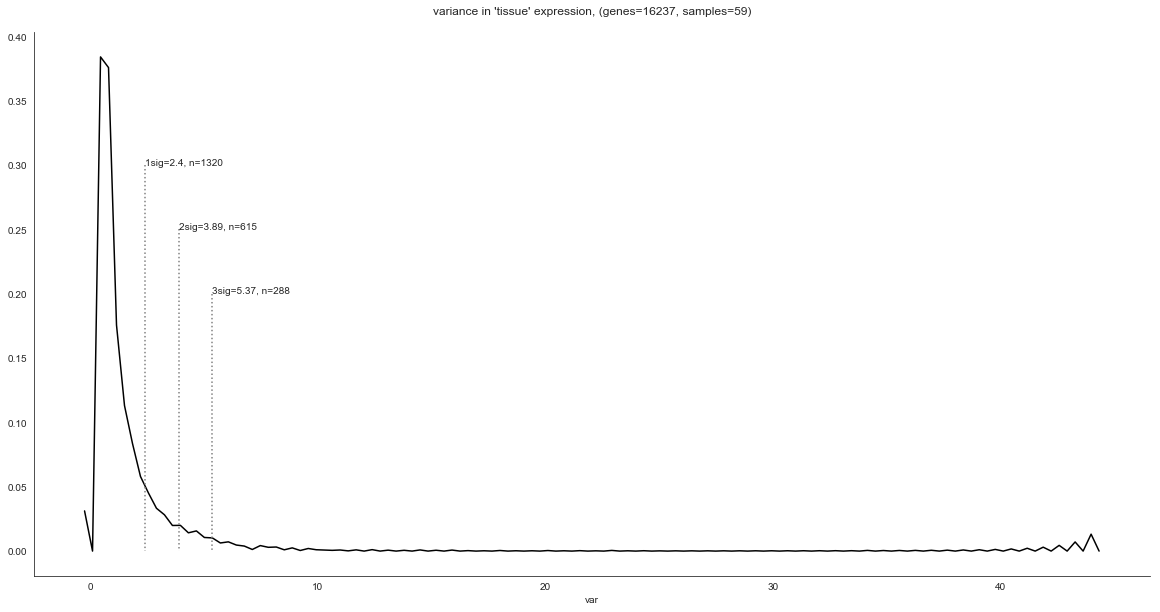

mean:  3.109752959341225
std:  4.487808451182486


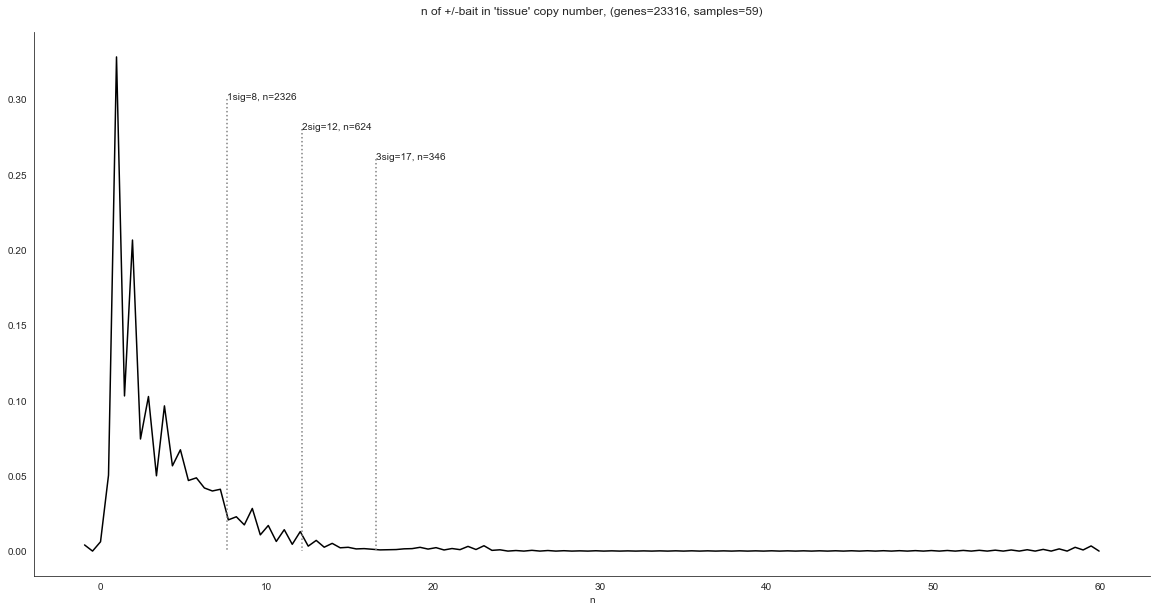

In [3]:
#load data
exp, cnv = clv.load_data('data/breast_mrna.tab.gz','data/breast_CCLE_DEL_calls.csv.gz') 

In [5]:
# only care about cnv groups with at least 3 samples
c3 = cnv[cnv.sum(axis=1) > 3]
    

In [6]:
def compute_true_negatives(expdf, cnvdf, nan_style='omit'):
    """
    compute expression of gene x when missing gene x
    
    :param expdf: pandas dataframe, expression by sample 
                    (hopefully filtered with mainFilter, tissue specific, with matching samples in cnv)
    :param cnvdf: pandas dataframe, binarized mask 5(1=delete, 0=nodelete) deletion by sample 
                    (hopefully filtered with mainFilter, tissue specific, with matching samples in exp)
    :param nan_style: str, how the stats.ttest_ind treats NANs, {‘propagate’, ‘raise’, ‘omit’}
    
    returns pandas dataframe with columns [exp, cnv, np_t_w, np_p_w]
    """
    cells = np.intersect1d(expdf.columns, cnvdf.columns)
    expdf = expdf[cells]
    cmask = cnvdf[cells] == 1
    negs = np.intersect1d(expdf.index, cnvdf.index)
    
    rdic = {'exp':[],'cnv':[], 'np_t_w':[], 'np_p_w':[]}

    comparisons = len(negs)
    print('attempting {} comparisons with current parameters'.format(comparisons))
    count=0
    percent_complete=0

    for n in np.intersect1d(c3.index, exp.index):
        rdic['exp'].append(n)
        rdic['cnv'].append(n)
        pos = np.array(expdf.loc[n][cmask.loc[n]])
        neg = np.array(expdf.loc[n][~cmask.loc[n]])
        t, p = stats.ttest_ind(pos, neg, nan_policy=nan_style, equal_var=True)
        rdic['np_t_w'].append(t)
        rdic['np_p_w'].append(p)

        # counter
        count+=1
        if count%(round(comparisons,-1)/10)==0:
            percent_complete+=10
            print('pair computation {}% complete ({}/{})'.format(percent_complete, count, comparisons))
            
    print('pair computation 100% complete!')        
    return pd.DataFrame(rdic)

In [7]:
neg_df=compute_true_negatives(exp, c3)

attempting 4797 comparisons with current parameters
pair computation 10% complete (480/4797)
pair computation 20% complete (960/4797)
pair computation 30% complete (1440/4797)
pair computation 40% complete (1920/4797)
pair computation 50% complete (2400/4797)
pair computation 60% complete (2880/4797)
pair computation 70% complete (3360/4797)
pair computation 80% complete (3840/4797)
pair computation 90% complete (4320/4797)
pair computation 100% complete!


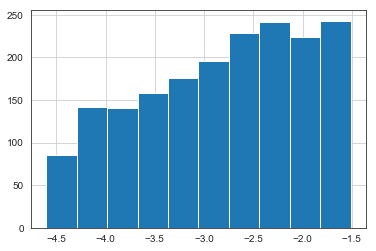

In [8]:
%matplotlib inline
neg_df['np_t_w'].hist()

In [9]:
neg_df.to_csv('data/clove_negatives_breast.tab.gz', sep='\t', compression='gzip')